## On power losses for semantic segmentation

A simple example of semantic segmentation on MNIST dataset to train an unet based model with different loss functions.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import tensorflow.keras.backend as K
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import os
from PIL import Image
import sys
from models import u_net_mod_lev
from utils import build_arrays_from_path, generator_from_list

tf.keras.backend.set_image_data_format("channels_last")

In [2]:
print(tf.__version__)
print(keras.__version__)

1.12.0
2.1.6-tf


Before running this notebook, do not forget to unzip the file data.zip in root directory

In [3]:
base_path = 'data/'

In [4]:
available_losses = [
    'categorical_crossentropy',
    'classical_jaccard',
    'jaccard_power_15', # p = 1.5
    'jaccard_power_20', # p = 2
    'classical_dice', 
    'dice_power_15', # p = 1.5
    'dice_power_20' # p = 2
]

Change the selected_loss in order to train a model with a different loss function. Other parameters such as nb_filters, batch_size and epochs can be modified in order to evaluate different scenarios

In [5]:
selected_loss = available_losses[3]
print("selected loss:", selected_loss)

selected loss: jaccard_power_20


In [6]:
nb_filters = 8 # [2, 4, 8]
batch_size = 10 # [1, 10, 50]

num_samples_train = 1000 # max 1000
epochs = 100

In [7]:
def jaccard_pow_loss(y_true, y_pred, p_value=2.0,smooth = 10):
    p_value = POWER_VALUE
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    term_true = K.sum(K.pow(y_true_f, p_value))
    term_pred = K.sum(K.pow(y_pred_f, p_value))
    union = term_true + term_pred - intersection
    return 1 - ((intersection + smooth) / (union + smooth))

def dice_pow_loss(y_true, y_pred,p_value=2.0, smooth = 10):
    p_value = POWER_VALUE
    y_true=K.flatten(y_true)
    y_pred=K.flatten(y_pred)
    numerator=K.sum(2*(y_true * y_pred))
    y_true = K.pow(y_true, p_value)
    y_pred = K.pow(y_pred, p_value)
    denominator = K.sum(y_true) +  K.sum(y_pred)
    return (1-((numerator+smooth)/(denominator+smooth)))


In [8]:
if selected_loss == 'categorical_crossentropy':
    loss = selected_loss
    POWER_VALUE = 0.0
elif selected_loss == 'classical_jaccard':
    loss = jaccard_pow_loss
    POWER_VALUE = 1.0
elif selected_loss == 'jaccard_power_15':
    loss = jaccard_pow_loss
    POWER_VALUE = 1.5
elif selected_loss == 'jaccard_power_20':
    loss = jaccard_pow_loss
    POWER_VALUE = 2.0   
elif selected_loss == 'classical_dice':
    loss = dice_pow_loss
    POWER_VALUE = 1.0
elif selected_loss == 'dice_power_15':
    loss = dice_pow_loss
    POWER_VALUE = 1.5    
elif selected_loss == 'dice_power_20':
    loss = dice_pow_loss
    POWER_VALUE = 2.0       

In [9]:
print("selected_loss", selected_loss)
print("p_value", POWER_VALUE)
print("filters", nb_filters)
print("batch_size", batch_size)

selected_loss jaccard_power_20
p_value 2.0
filters 8
batch_size 10


In [10]:
# Other parameters
noise_rate = 0.1
num_samples_val = int(num_samples_train*0.2)
patience_epochs = 5
conv_sampling = True
HEIGHT, WIDTH = 32, 32
N_CLASSES = 10

In [11]:
base_path_train = base_path + 'train'
pathimagetrain = base_path_train +'/images/'
pathgttrain= base_path_train + '/gt/'

base_path_validation = base_path + 'validation'
pathimageval = base_path_validation +'/images/'
pathgtval= base_path_validation + '/gt/'     

In [12]:
list_train_images = os.listdir(pathimagetrain)
list_train_images.sort()
list_train_images = list_train_images[:num_samples_train]

list_validation_images = os.listdir(pathimageval)
list_validation_images.sort()
list_validation_images = list_validation_images[:num_samples_val]

print("list_train_images", len(list_train_images) )
print("list_train_images", len(list_validation_images) )

list_train_images 1000
list_train_images 200


In [13]:
train_generator = generator_from_list(pathimagetrain, list_train_images, pathgttrain, N_CLASSES, HEIGHT, WIDTH, is_train_set=True, batch_size=batch_size)
val_generator = generator_from_list(pathimageval, list_validation_images, pathgtval, N_CLASSES, HEIGHT, WIDTH, is_train_set=False, batch_size=batch_size)

In [14]:
model = u_net_mod_lev((HEIGHT, WIDTH, 1), nb_levels = 4, nb_filters_0 = nb_filters, output_channels = N_CLASSES, sigma_noise = noise_rate, conv_sampling = conv_sampling)
model.summary()

model.compile(loss=loss,
              optimizer=keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

cb = [
    EarlyStopping(monitor='val_loss', patience=patience_epochs, verbose=0, mode='min'),
    #ModelCheckpoint(output_model, save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min'),
    #CSVLogger(csv_path, separator=',', append=True)
]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 32, 32, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 8)    0           conv1_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 32, 32, 8)    584         activation[0][0]                 
__________________________________________________________________________________________________
activation

In [15]:
H = model.fit_generator(train_generator,
                    epochs=epochs, 
                    steps_per_epoch = num_samples_train // batch_size,
                    validation_data=val_generator,
                    validation_steps=num_samples_val // batch_size,
                    callbacks= cb,
                    verbose=2
         )

Epoch 1/100
 - 5s - loss: 0.9051 - acc: 0.2376 - val_loss: 0.8331 - val_acc: 0.0264
Epoch 2/100
 - 3s - loss: 0.8257 - acc: 0.5153 - val_loss: 0.8090 - val_acc: 0.8337
Epoch 3/100
 - 3s - loss: 0.7623 - acc: 0.5255 - val_loss: 0.6965 - val_acc: 0.1166
Epoch 4/100
 - 3s - loss: 0.6754 - acc: 0.1216 - val_loss: 0.6490 - val_acc: 0.0820
Epoch 5/100
 - 3s - loss: 0.6252 - acc: 0.0877 - val_loss: 0.6019 - val_acc: 0.0978
Epoch 6/100
 - 3s - loss: 0.5779 - acc: 0.0995 - val_loss: 0.6419 - val_acc: 0.1063
Epoch 7/100
 - 3s - loss: 0.4993 - acc: 0.1146 - val_loss: 0.4876 - val_acc: 0.1375
Epoch 8/100
 - 3s - loss: 0.4432 - acc: 0.1184 - val_loss: 0.3936 - val_acc: 0.1325
Epoch 9/100
 - 3s - loss: 0.3692 - acc: 0.1378 - val_loss: 0.3507 - val_acc: 0.1417
Epoch 10/100
 - 3s - loss: 0.3451 - acc: 0.1416 - val_loss: 0.3526 - val_acc: 0.1585
Epoch 11/100
 - 3s - loss: 0.2550 - acc: 0.1485 - val_loss: 0.3455 - val_acc: 0.1429
Epoch 12/100
 - 3s - loss: 0.2595 - acc: 0.1519 - val_loss: 0.3100 - val_a

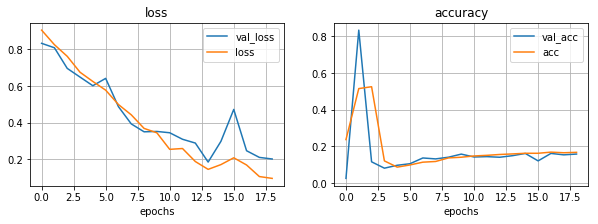

In [16]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title("loss")
plt.plot(H.history['val_loss'], label='val_loss')
plt.plot(H.history['loss'], label='loss')
plt.xlabel("epochs")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("accuracy")
plt.plot(H.history['val_acc'], label='val_acc')
plt.plot(H.history['acc'], label='acc')
plt.legend()
plt.xlabel("epochs")
plt.grid()
plt.show()

## Some predictions on test set using trained model

In [17]:
base_path_test = base_path + 'test'
pathimagetest = base_path_test +'/images/'
pathgttest= base_path_test + '/gt/'

xtest, ytest = build_arrays_from_path(pathimagetest, pathgttest)

In [18]:
number_of_tests = 10

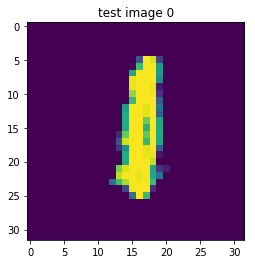

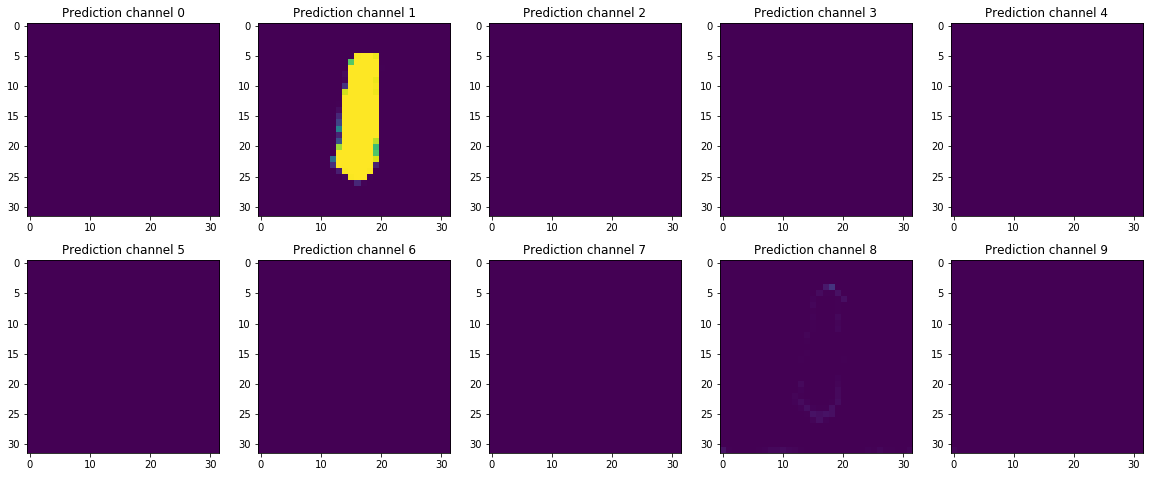

**********
**********
**********


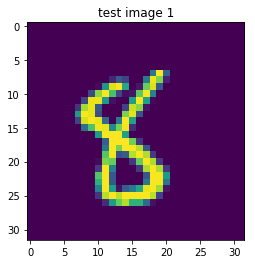

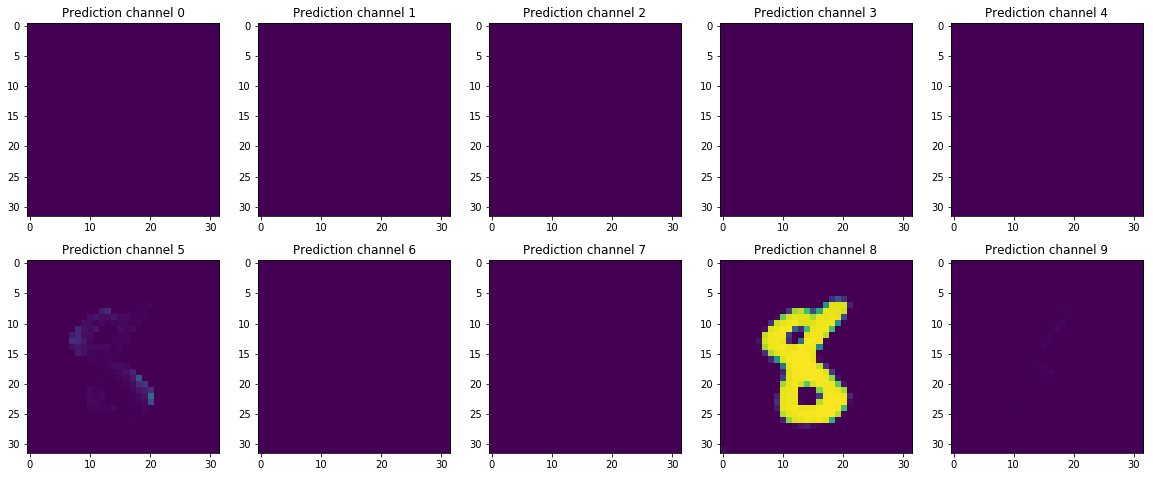

**********
**********
**********


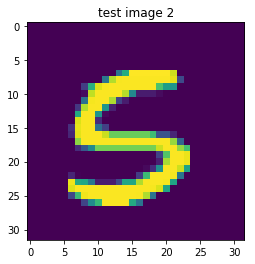

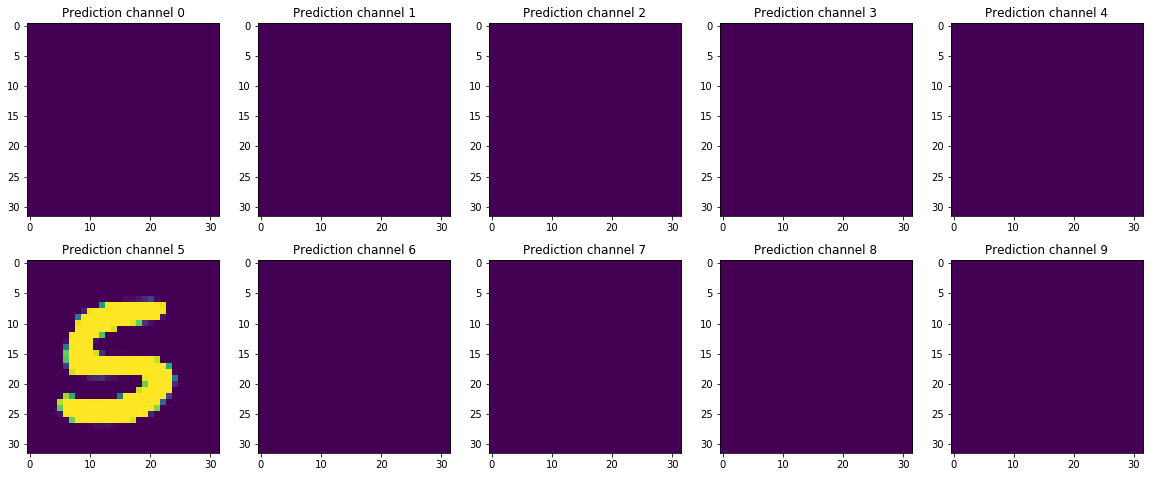

**********
**********
**********


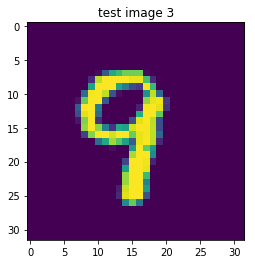

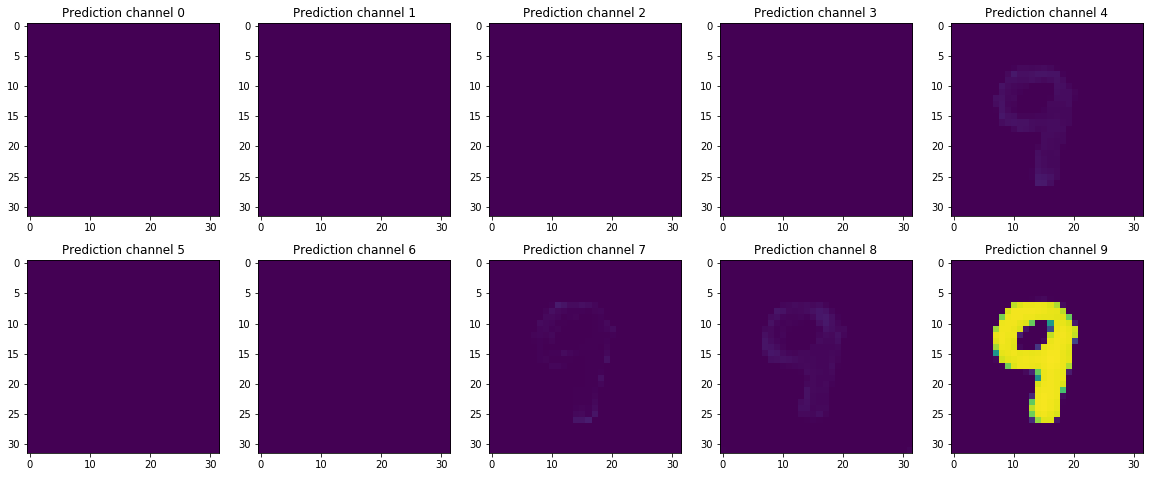

**********
**********
**********


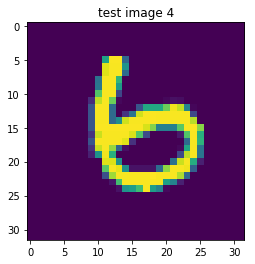

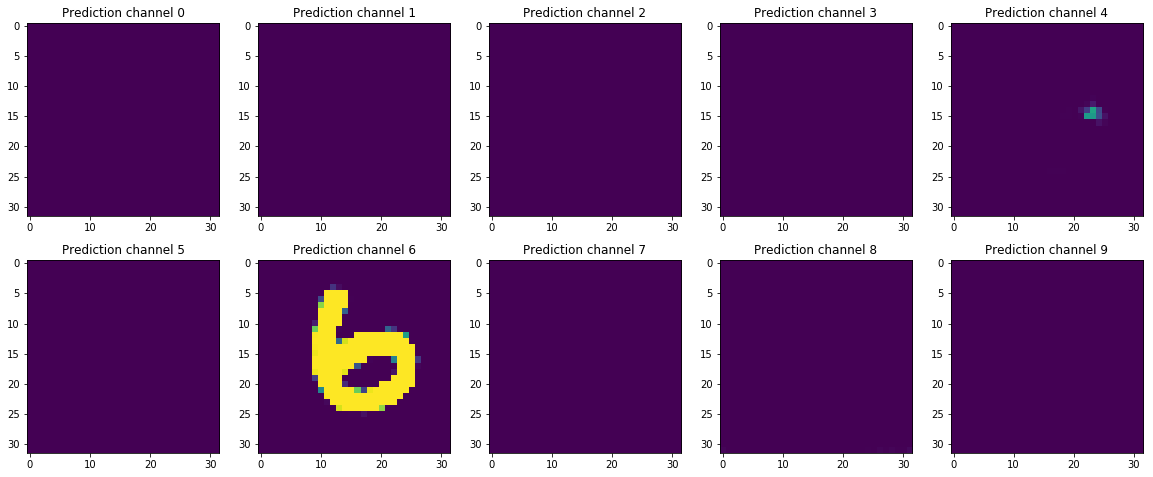

**********
**********
**********


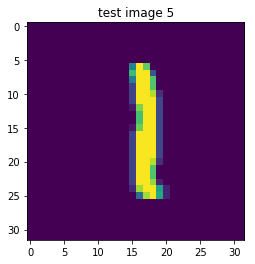

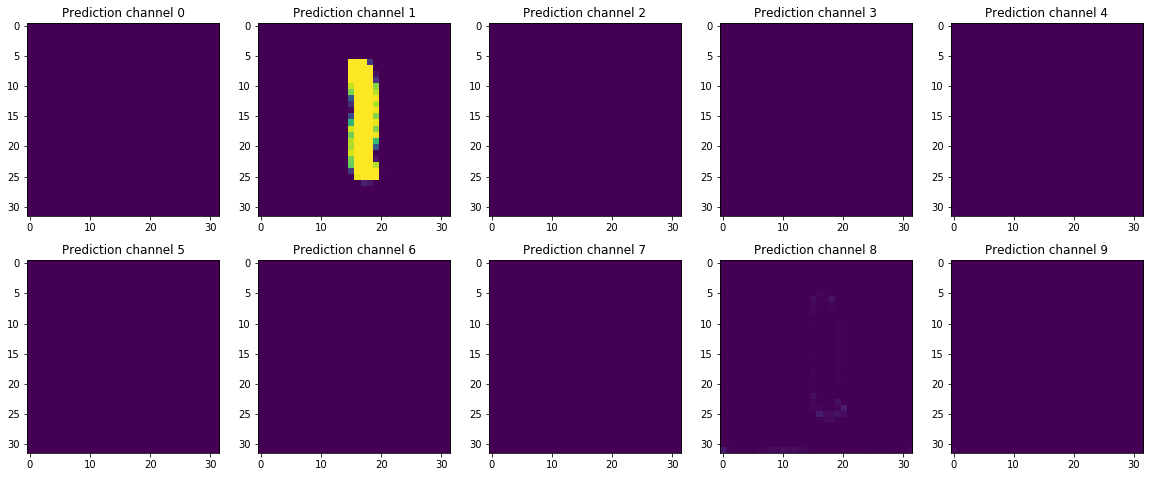

**********
**********
**********


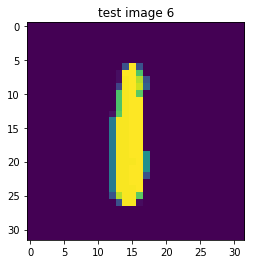

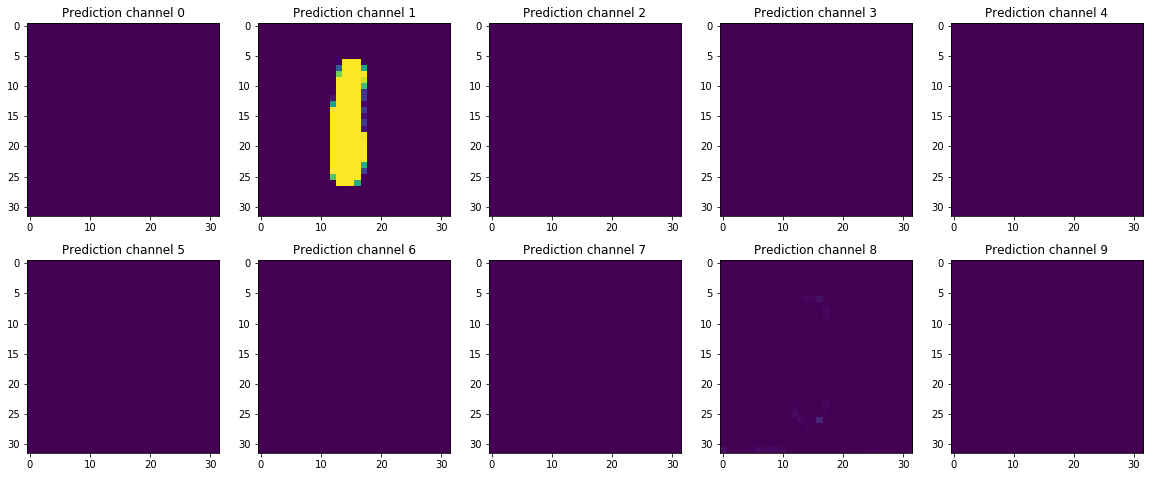

**********
**********
**********


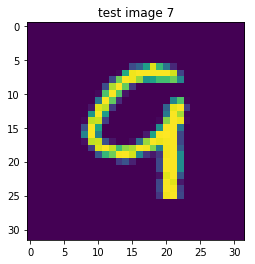

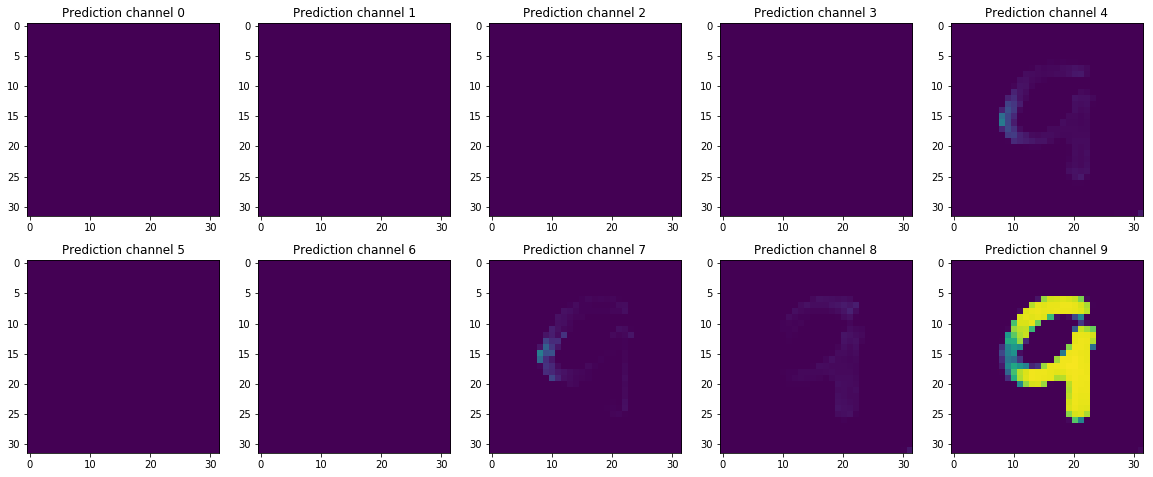

**********
**********
**********


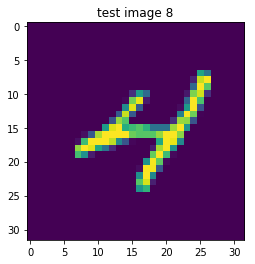

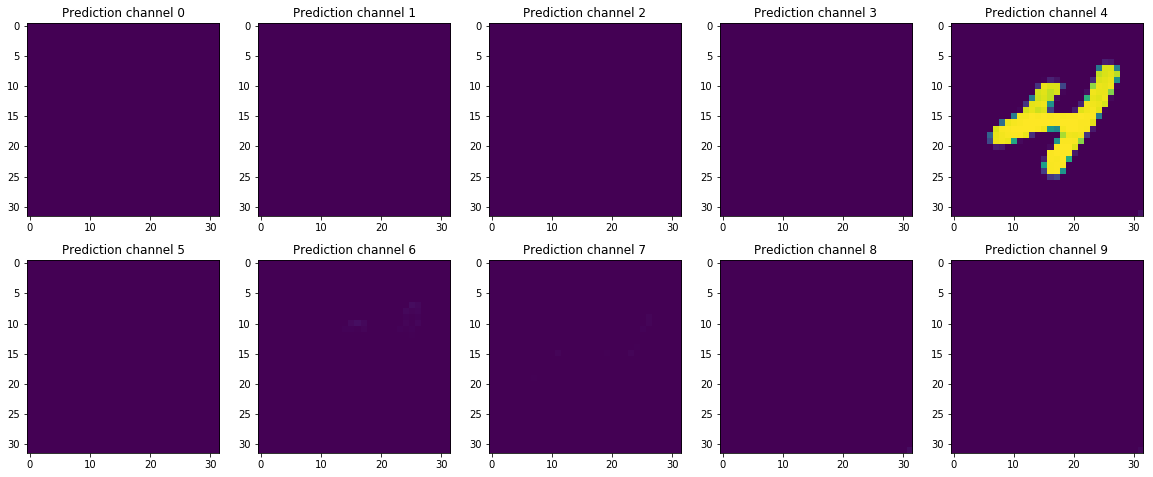

**********
**********
**********


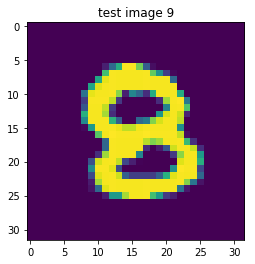

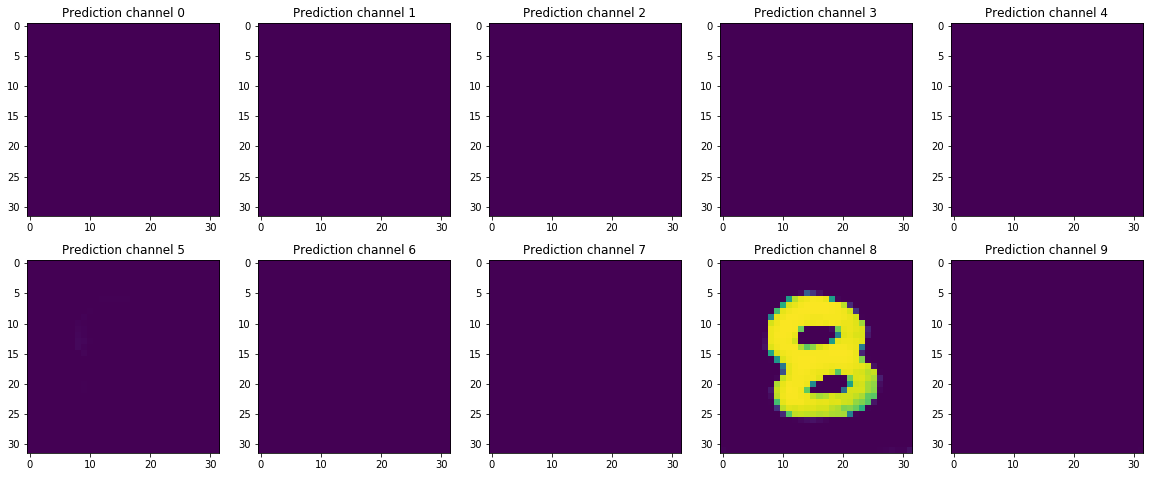

**********
**********
**********


In [19]:
for k in range(number_of_tests):
    i = np.random.randint(xtest.shape[0])
    sample_to_predict = xtest[i,:,:,:]
    sample_to_predict = np.expand_dims(sample_to_predict, 0)
    y_pred = model.predict(sample_to_predict)    
    
    # Show input image
    plt.title("test image " + str(k) )
    plt.imshow(sample_to_predict[0,:,:,0])
    plt.show()

    # Show predictions
    plt.figure(figsize=(20,8))
    for j in range(N_CLASSES):
        plt.subplot(2,5,j + 1)
        plt.title("Prediction channel " + str(j))
        plt.imshow(y_pred[0,:,:,j], vmin=0, vmax=1)
    plt.show() 
    print("*"*10)
    print("*"*10)
    print("*"*10)  